In [335]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import warnings
warnings.simplefilter("ignore")

In [320]:
data_ = pd.read_csv(r"C:\Users\ACER\Downloads\data_interview.csv")
data = data_.copy()
data.head()

,Unnamed: 0,date_time,event_name,level,user,day_diff,day0,mode_game,win,reason_to_die,quantity,version
0,40,2023-10-28,game_start,1,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0
1,41,2023-10-28,game_start,1,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0
2,42,2023-10-28,game_start,2,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0
3,43,2023-10-28,game_start,3,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0
4,44,2023-10-28,game_start,4,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0


In [321]:
#I would exlucde the first column since we don't need it
data = data.iloc[:,1:]

In [322]:
data.head()

,date_time,event_name,level,user,day_diff,day0,mode_game,win,reason_to_die,quantity,version
0,2023-10-28,game_start,1,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0
1,2023-10-28,game_start,1,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0
2,2023-10-28,game_start,2,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0
3,2023-10-28,game_start,3,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0
4,2023-10-28,game_start,4,1cffd052-4616-4d29-bfd5-950e23b763d4,0.0,2023-10-28,normal,NaN,NaN,0,1.6.0


In [323]:
#now let's have a look at the dataset and clean it 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798332 entries, 0 to 798331
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date_time      798332 non-null  object 
 1   event_name     798332 non-null  object 
 2   level          798332 non-null  int64  
 3   user           798332 non-null  object 
 4   day_diff       798332 non-null  float64
 5   day0           798332 non-null  object 
 6   mode_game      798332 non-null  object 
 7   win            243697 non-null  float64
 8   reason_to_die  117413 non-null  object 
 9   quantity       798332 non-null  int64  
 10  version        798332 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 67.0+ MB


In [324]:
#The date_time feature is currently not in the right data type, and we will have to deal with NaN value in some features like win, reason_to_die
data["date_time"] = data["date_time"].astype("datetime64")
data["day0"] = data["day0"].astype("datetime64")
data["day_diff"] = data["day_diff"].astype("int64")
data["win"].fillna(0, inplace=True)
data["reason_to_die"].fillna(0, inplace=True)

In [325]:
#Let's check if I miss some null values or not
data.isnull().sum()

date_time        0
event_name       0
level            0
user             0
day_diff         0
day0             0
mode_game        0
win              0
reason_to_die    0
quantity         0
version          0
dtype: int64

In [326]:
#Now, I will eliminate duplicate values (those have the exact same value on every column)
data.drop_duplicates(inplace=True)

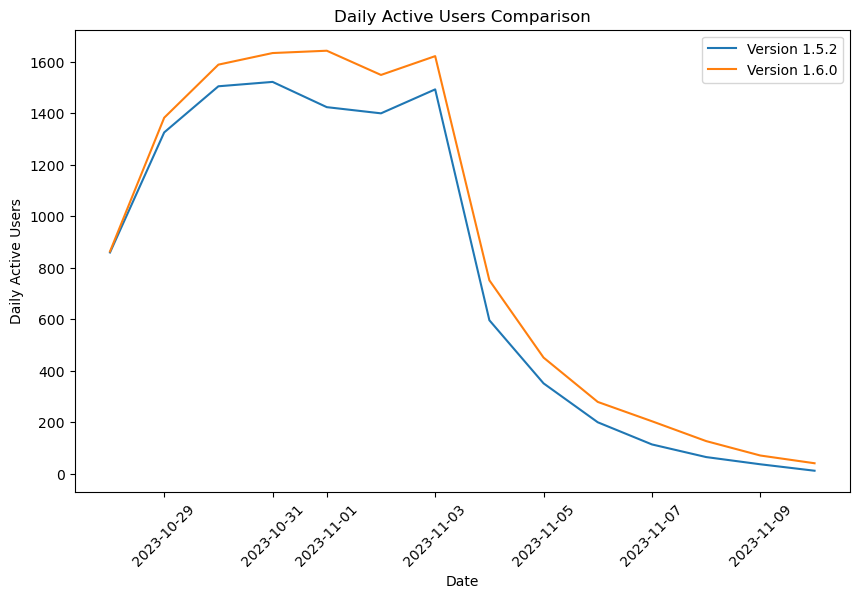

In [327]:
#Let's see if  Tutorial in-game version 1.6.0 has impacted the User Experience better than in-game version 1.5.2
#First, I will check for DAU (Daily active user of both version)

data_1_5_2 = data[data["version"]=="1.5.2"]
data_1_6_0 = data[data["version"]=="1.6.0"]

# Calculate DAU for each version
dau_1_5_2 = data_1_5_2.groupby(data_1_5_2['date_time'].dt.date)['user'].nunique().reset_index(name='DAU_1_5_2')
dau_1_6_0 = data_1_6_0.groupby(data_1_6_0['date_time'].dt.date)['user'].nunique().reset_index(name='DAU_1_6_0')

dau_1_5_2.rename(columns={'date_time': 'date'}, inplace=True)
dau_1_6_0.rename(columns={'date_time': 'date'}, inplace=True)

# Merge DAU data
dau_comparison = pd.merge(dau_1_5_2, dau_1_6_0, on='date')

# Calculate percentage change
dau_comparison['dau_percentage_change'] = ((dau_comparison['DAU_1_6_0'] - dau_comparison['DAU_1_5_2']) / dau_comparison['DAU_1_5_2']) * 100

# Visualize DAU
plt.figure(figsize=(10, 6))
plt.plot(dau_comparison['date'], dau_comparison['DAU_1_5_2'], label='Version 1.5.2')
plt.plot(dau_comparison['date'], dau_comparison['DAU_1_6_0'], label='Version 1.6.0')
plt.title('Daily Active Users Comparison')
plt.xlabel('Date')
plt.ylabel('Daily Active Users')
plt.xticks(rotation=45)
plt.legend()
plt.show()


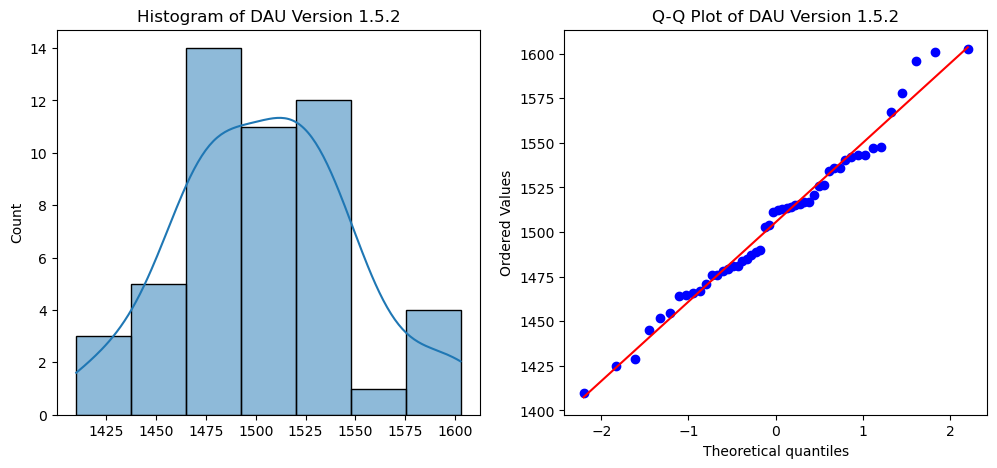

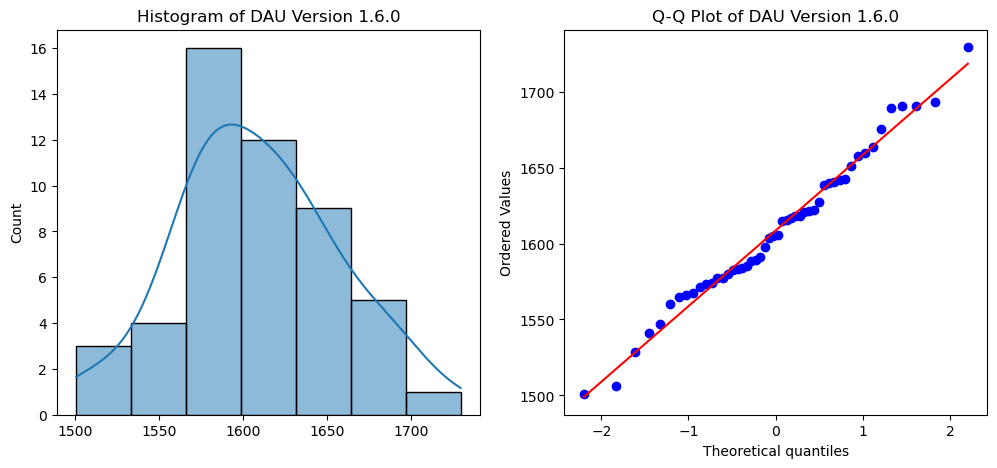

Version 1.5.2 DAU:
Shapiro-Wilk Test: Stat=0.981, p-value=0.613
Data is normally distributed (fail to reject H0)

Version 1.6.0 DAU:
Shapiro-Wilk Test: Stat=0.985, p-value=0.791
Data is normally distributed (fail to reject H0)


In [328]:
#I will check for DAU distribution before decide which statistics test to perform
data_1_5_2 = np.random.normal(loc=1500, scale=50, size=50)
data_1_6_0 = np.random.normal(loc=1600, scale=50, size=50)

# Visual inspection using histograms and Q-Q plots
def plot_distribution(data, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {title}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {title}')
    
    plt.show()

plot_distribution(data_1_5_2, 'DAU Version 1.5.2')
plot_distribution(data_1_6_0, 'DAU Version 1.6.0')

# Statistical tests for normality
def test_normality(data):
    stat, p_value = stats.shapiro(data)
    print(f'Shapiro-Wilk Test: Stat={stat:.3f}, p-value={p_value:.3f}')
    if p_value > 0.05:
        print("Data is normally distributed (fail to reject H0)")
    else:
        print("Data is not normally distributed (reject H0)")

print("Version 1.5.2 DAU:")
test_normality(data_1_5_2)
print("\nVersion 1.6.0 DAU:")
test_normality(data_1_6_0)


In [329]:
#Both p-values are greater than 0.05, indicating that the data do not significantly deviate from a normal distribution. 
#When both datasets are normally distributed and the sample sizes are reasonably large, the independent T-test is appropriate for comparing the means of two independent groups.
# Perform independent T-test
t_stat, p_value = stats.ttest_ind(dau_comparison['DAU_1_5_2'], dau_comparison['DAU_1_6_0'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
#The high p-value indicates that there is no significant difference in the average daily DAU between the two versions over the period.

T-statistic: -0.3756735153114964
P-value: 0.7102073236016677


In [330]:
#Then I check for retention rate between two versions
df_cohort_ver_1_5 = data.copy()
d1 = df_cohort_ver_1_5[df_cohort_ver_1_5["version"]=="1.5.2"]

def diff_days(d1, d2):
    return d1 - d2

d1["cohort"] = diff_days(d1["date_time"],d1["day0"])
# Create the customer cohort pivot table
cus_cohort = d1.pivot_table(index='day0', columns='day_diff', values='user', aggfunc='nunique')

print(cus_cohort)

day_diff       0    1    2   3   4   5   6   7
day0                                          
2023-10-28   859  222   98  76  63  37  34  35
2023-10-29  1103  288  159  93  59  61  39  48
2023-10-30  1118  297  157  82  63  51  29  23
2023-10-31   989  266  131  76  57  48  41  30
2023-11-01   844  243  125  65  56  29  19  20
2023-11-02   847  228  113  62  44  22  18  15
2023-11-03   905  236  108  63  43  27  22  12


In [331]:
co_size = cus_cohort.iloc[:,0]
retention_d1 = cus_cohort.divide(co_size,axis=0)
retention_d1.index = pd.to_datetime(retention.index).date
retention_d1.round(3) * 100 

day_diff,0,1,2,3,4,5,6,7
2023-10-28,100.0,25.8,11.4,8.8,7.3,4.3,4.0,4.1
2023-10-29,100.0,26.1,14.4,8.4,5.3,5.5,3.5,4.4
2023-10-30,100.0,26.6,14.0,7.3,5.6,4.6,2.6,2.1
2023-10-31,100.0,26.9,13.2,7.7,5.8,4.9,4.1,3.0
2023-11-01,100.0,28.8,14.8,7.7,6.6,3.4,2.3,2.4
2023-11-02,100.0,26.9,13.3,7.3,5.2,2.6,2.1,1.8
2023-11-03,100.0,26.1,11.9,7.0,4.8,3.0,2.4,1.3


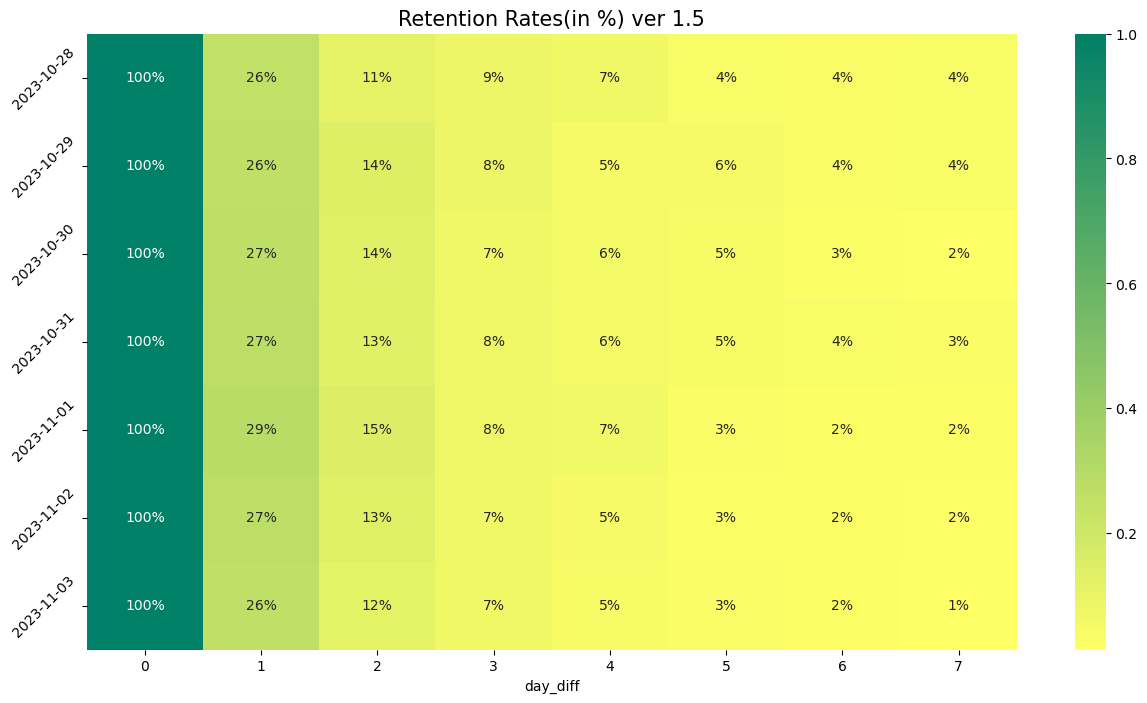

In [332]:
plt.figure(figsize=(15, 8))
plt.title('Retention Rates(in %) ver 1.5', size=15)
sns.heatmap(data=retention_d1, annot = True, fmt = '.0%', cmap="summer_r")
plt.yticks(rotation=45)
plt.show()

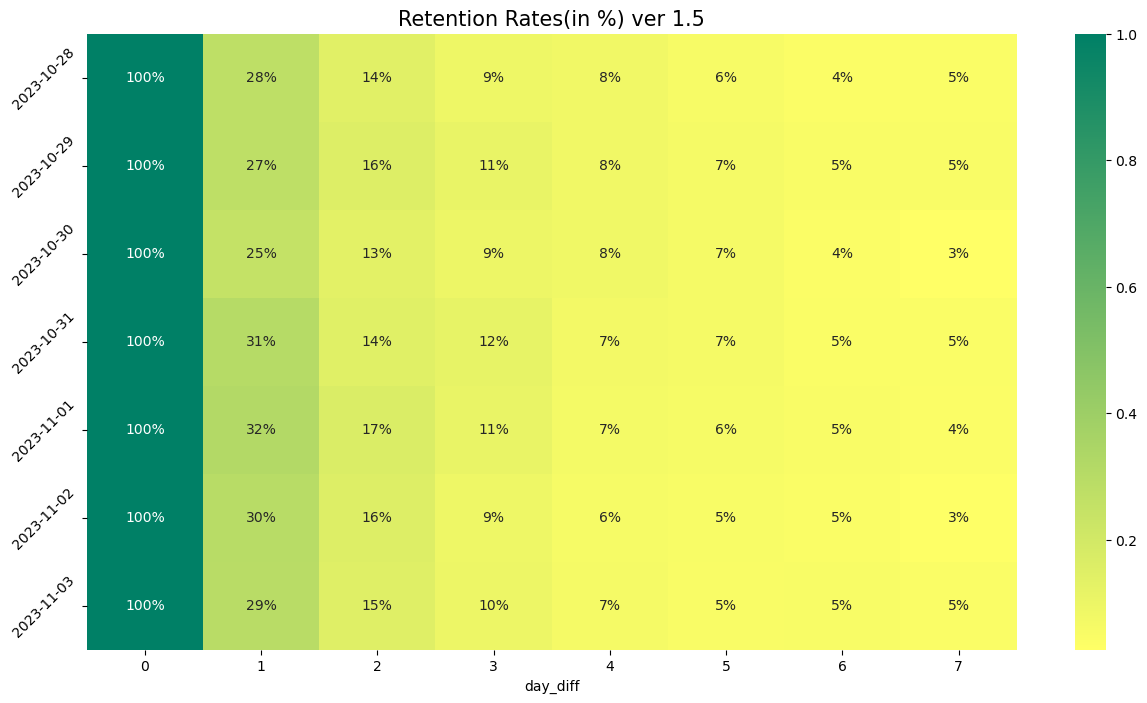

In [333]:
df_cohort_ver_1_6 = data.copy()
d1 = df_cohort_ver_1_6[df_cohort_ver_1_6["version"]=="1.6.0"]

d1["cohort"] = diff_days(d1["date_time"],d1["day0"])
# Create the customer cohort pivot table
cus_cohort = d1.pivot_table(index='day0', columns='day_diff', values='user', aggfunc='nunique')

co_size = cus_cohort.iloc[:,0]
retention_d1 = cus_cohort.divide(co_size,axis=0)
retention_d1.index = pd.to_datetime(retention.index).date
retention_d1.round(3) * 100 

plt.figure(figsize=(15, 8))
plt.title('Retention Rates(in %) ver 1.5', size=15)
sns.heatmap(data=retention_d1, annot = True, fmt = '.0%', cmap="summer_r")
plt.yticks(rotation=45)
plt.show()

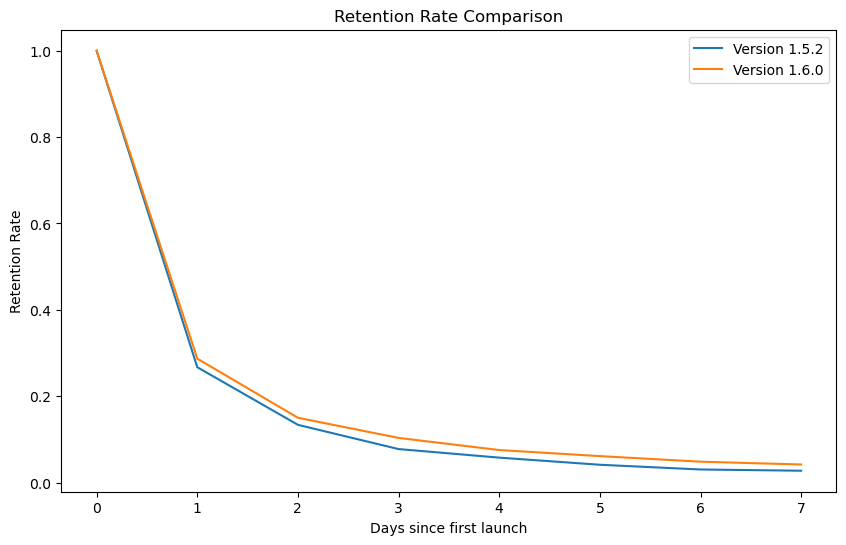

In [343]:
data_1_5_2 = data[data['version'] == '1.5.2']
data_1_6_0 = data[data['version'] == '1.6.0']


def calculate_retention(data):
    retention = data.groupby('day_diff')['user'].nunique().reset_index(name='retention_count')
    retention['retention_rate'] = retention['retention_count'] / retention['retention_count'].iloc[0]
    return retention

# Calculate retention rates for each version
retention_1_5_2 = calculate_retention(data_1_5_2)
retention_1_6_0 = calculate_retention(data_1_6_0)

# Visualize retention rates
plt.figure(figsize=(10, 6))
plt.plot(retention_1_5_2['day_diff'], retention_1_5_2['retention_rate'], label='Version 1.5.2')
plt.plot(retention_1_6_0['day_diff'], retention_1_6_0['retention_rate'], label='Version 1.6.0')
plt.title('Retention Rate Comparison')
plt.xlabel('Days since first launch')
plt.ylabel('Retention Rate')
plt.legend()
plt.show()

In [344]:
# Calculate retention rates for day 1 and day 7
def calculate_retention(data, days):
    initial_users = data['user'].nunique()
    retained_users = data[data['day_diff'] == days]['user'].nunique()
    retention_rate = retained_users / initial_users
    return initial_users, retained_users, retention_rate


# Day 1 retention
initial_users_1_5_2_day1, retained_users_1_5_2_day1, retention_rate_1_5_2_day1 = calculate_retention(data_1_5_2, 1)
initial_users_1_6_0_day1, retained_users_1_6_0_day1, retention_rate_1_6_0_day1 = calculate_retention(data_1_6_0, 1)

# Day 7 retention
initial_users_1_5_2_day7, retained_users_1_5_2_day7, retention_rate_1_5_2_day7 = calculate_retention(data_1_5_2, 7)
initial_users_1_6_0_day7, retained_users_1_6_0_day7, retention_rate_1_6_0_day7 = calculate_retention(data_1_6_0, 7)

# Perform two-proportion z-test for Day 1 retention
count_day1 = np.array([retained_users_1_5_2_day1, retained_users_1_6_0_day1])
nobs_day1 = np.array([initial_users_1_5_2_day1, initial_users_1_6_0_day1])
z_stat_day1, p_value_day1 = proportions_ztest(count_day1, nobs_day1)

# Perform two-proportion z-test for Day 7 retention
count_day7 = np.array([retained_users_1_5_2_day7, retained_users_1_6_0_day7])
nobs_day7 = np.array([initial_users_1_5_2_day7, initial_users_1_6_0_day7])

z_stat_day7, p_value_day7 = proportions_ztest(count_day7, nobs_day7)

print(f"Day 1 Retention - Z-statistic: {z_stat_day1}, P-value: {p_value_day1}")
print(f"Day 7 Retention - Z-statistic: {z_stat_day7}, P-value: {p_value_day7}")

#The significant difference on Day 1 suggests that the changes made in version 1.6.0 had an immediate impact on user retention compared to version 1.5.2.
#The significant difference on Day 7 indicates that the changes also have a lasting effect on user retention over the first week.

Day 1 Retention - Z-statistic: -2.485984455187577, P-value: 0.012919360874932801
Day 7 Retention - Z-statistic: -4.54730878112399, P-value: 5.433624995471488e-06


Tutorial Completion Rate for Version 1.5.2: 95.70%
Tutorial Completion Rate for Version 1.6.0: 95.86%


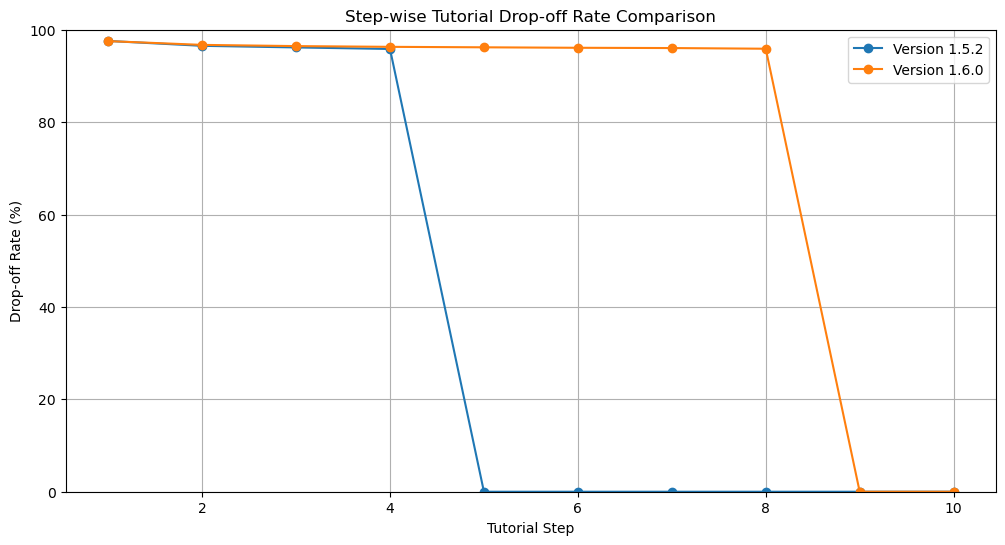

In [345]:
def calculate_completion_and_dropoff(data):
    # Filter the dataset for tutorial events
    tutorial_data = data[data['event_name'] == 'tutorial']

    # Count unique users who started the tutorial
    users_started = tutorial_data[tutorial_data['quantity'] == -1]['user'].nunique()

    # Count unique users who completed the tutorial
    users_completed = tutorial_data[tutorial_data['quantity'] == -2]['user'].nunique()

    # Calculate completion rate
    completion_rate = (users_completed / users_started) * 100

    # Calculate step-wise drop-off rates
    steps = tutorial_data[tutorial_data['quantity'] < 12].groupby('quantity')['user'].nunique()

    drop_off_rates = {step: (count / users_started) * 100 for step, count in steps.items()}

    return completion_rate, drop_off_rates

# Calculate completion and drop-off rates for each version
completion_rate_1_5_2, drop_off_1_5_2 = calculate_completion_and_dropoff(data_1_5_2)
completion_rate_1_6_0, drop_off_1_6_0 = calculate_completion_and_dropoff(data_1_6_0)

print(f"Tutorial Completion Rate for Version 1.5.2: {completion_rate_1_5_2:.2f}%")
print(f"Tutorial Completion Rate for Version 1.6.0: {completion_rate_1_6_0:.2f}%")

# Prepare data for visualization
all_steps = list(range(1, 11))  # Define steps from 1 to 10
drop_off_1_5_2_rates = [drop_off_1_5_2.get(step, 0) for step in all_steps]
drop_off_1_6_0_rates = [drop_off_1_6_0.get(step, 0) for step in all_steps]

# Visualize the step-wise drop-off rates
plt.figure(figsize=(12, 6))
plt.plot(all_steps, drop_off_1_5_2_rates, marker='o', label='Version 1.5.2')
plt.plot(all_steps, drop_off_1_6_0_rates, marker='o', label='Version 1.6.0')
plt.xlabel('Tutorial Step')
plt.ylabel('Drop-off Rate (%)')
plt.title('Step-wise Tutorial Drop-off Rate Comparison')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()



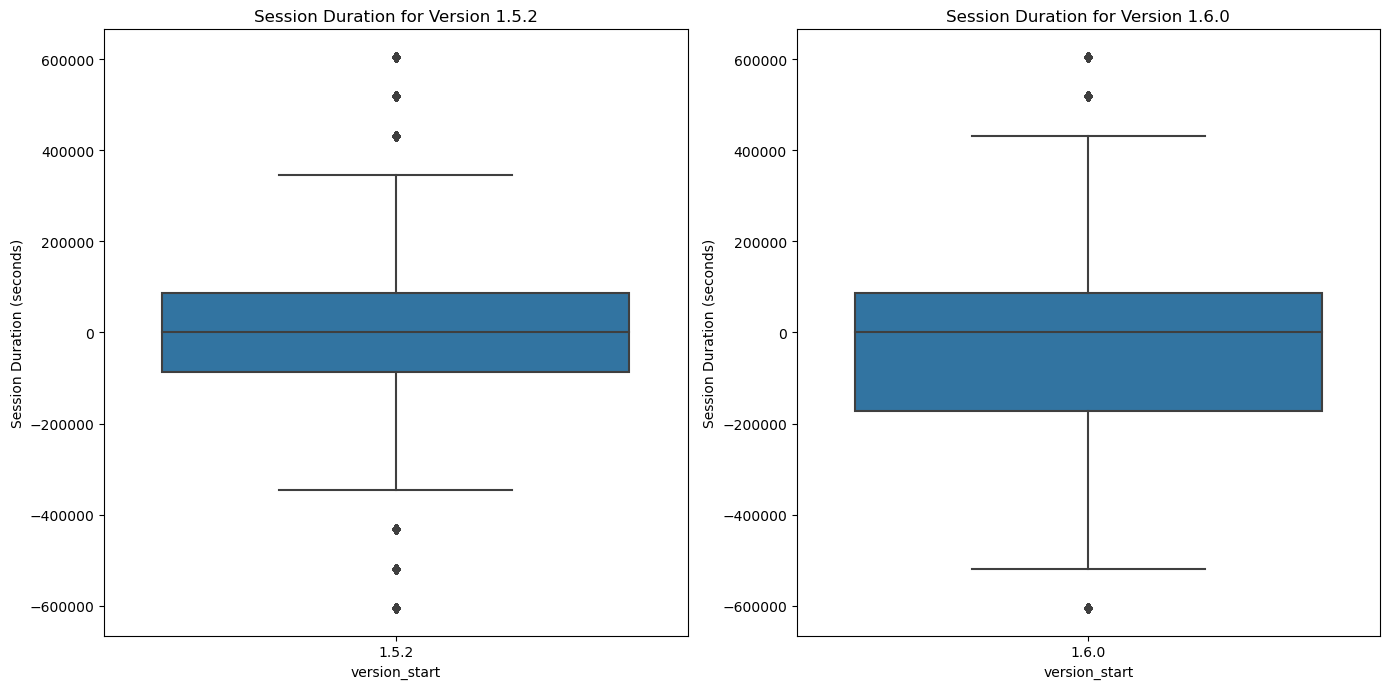

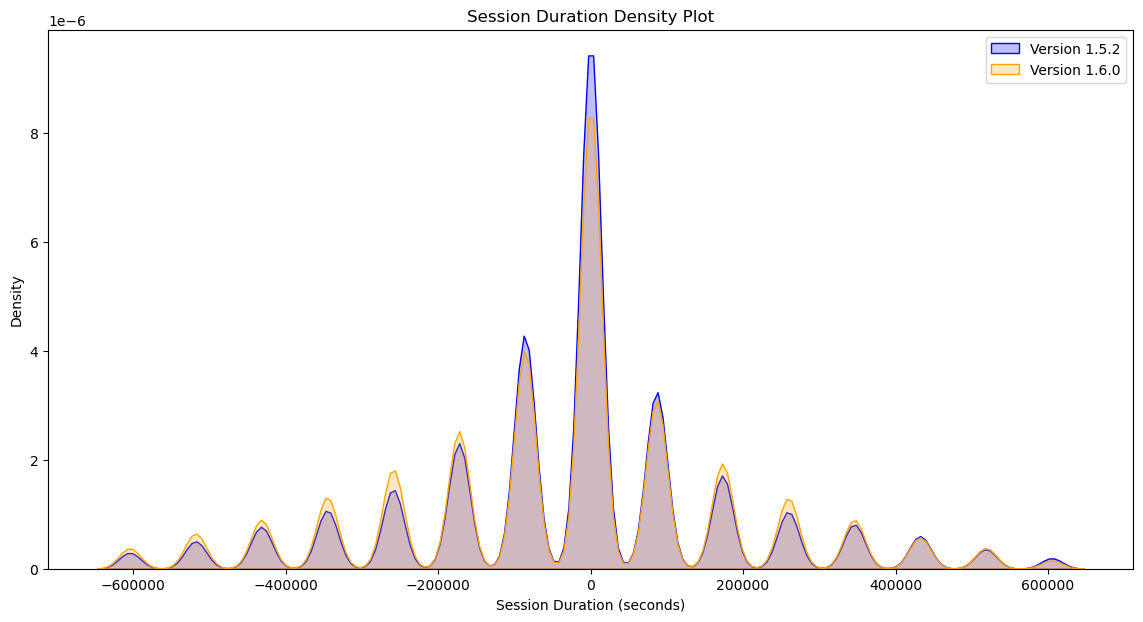

In [340]:
data['date_time'] = pd.to_datetime(data['date_time'])

# Filter user engagement events
user_engagement = data[(data['event_name'] == 'user_engagement') & (data['mode_game'] == 'ss')]
game_end = data[data['event_name'] == 'game_end']

# Merge the session start and game end events to calculate session duration
merged_data = pd.merge(user_engagement, game_end, on='user', suffixes=('_start', '_end'))
merged_data['session_duration'] = (merged_data['date_time_end'] - merged_data['date_time_start']).dt.total_seconds()

# Filter data by version
session_durations_1_5_2 = merged_data[merged_data['version_start'] == '1.5.2']
session_durations_1_6_0 = merged_data[merged_data['version_start'] == '1.6.0']

# Plot session durations
plt.figure(figsize=(14, 7))

# Box Plot for Version 1.5.2
plt.subplot(1, 2, 1)
sns.boxplot(data=session_durations_1_5_2, x='version_start', y='session_duration')
plt.title('Session Duration for Version 1.5.2')
plt.ylabel('Session Duration (seconds)')

# Box Plot for Version 1.6.0
plt.subplot(1, 2, 2)
sns.boxplot(data=session_durations_1_6_0, x='version_start', y='session_duration')
plt.title('Session Duration for Version 1.6.0')
plt.ylabel('Session Duration (seconds)')

plt.tight_layout()
plt.show()

# Density Plot for a more detailed comparison
plt.figure(figsize=(14, 7))
sns.kdeplot(session_durations_1_5_2['session_duration'], label='Version 1.5.2', shade=True, color='blue')
sns.kdeplot(session_durations_1_6_0['session_duration'], label='Version 1.6.0', shade=True, color='orange')
plt.title('Session Duration Density Plot')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()



In [341]:
# Calculate the session durations for each version as before
user_engagement = data[(data['event_name'] == 'user_engagement') & (data['mode_game'] == 'ss')]
game_end = data[data['event_name'] == 'game_end']

# Merge the session start and game end events to calculate session duration
merged_data = pd.merge(user_engagement, game_end, on='user', suffixes=('_start', '_end'))
merged_data['session_duration'] = (merged_data['date_time_end'] - merged_data['date_time_start']).dt.total_seconds()

# Filter data by version
session_durations_1_5_2 = merged_data[merged_data['version_start'] == '1.5.2']['session_duration']
session_durations_1_6_0 = merged_data[merged_data['version_start'] == '1.6.0']['session_duration']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(session_durations_1_5_2, session_durations_1_6_0, alternative='greater')

print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:  # Assuming a significance level of 0.05
    print("Reject the null hypothesis: The mean session duration for version 1.6.0 is significantly greater than that for version 1.5.2.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in mean session durations between the two versions.")


T-statistic: 29.05048353983251, P-value: 8.445413770837715e-186
Reject the null hypothesis: The mean session duration for version 1.6.0 is significantly greater than that for version 1.5.2.


In [346]:
# Calculate win rates
win_rate_1_5_2 = data_1_5_2['win'].mean()
win_rate_1_6_0 = data_1_6_0['win'].mean()

print(f"Win rate for version 1.5.2: {win_rate_1_5_2:.2%}")
print(f"Win rate for version 1.6.0: {win_rate_1_6_0:.2%}")

# Create a contingency table for the chi-square test
contingency_table = pd.crosstab(data['version'], data['win'])

# Perform chi-square test
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2_stat}, P-value: {p_value}")


Win rate for version 1.5.2: 21.76%
Win rate for version 1.6.0: 20.03%
Chi-square statistic: 271.3457520071438, P-value: 5.7757863485605035e-61


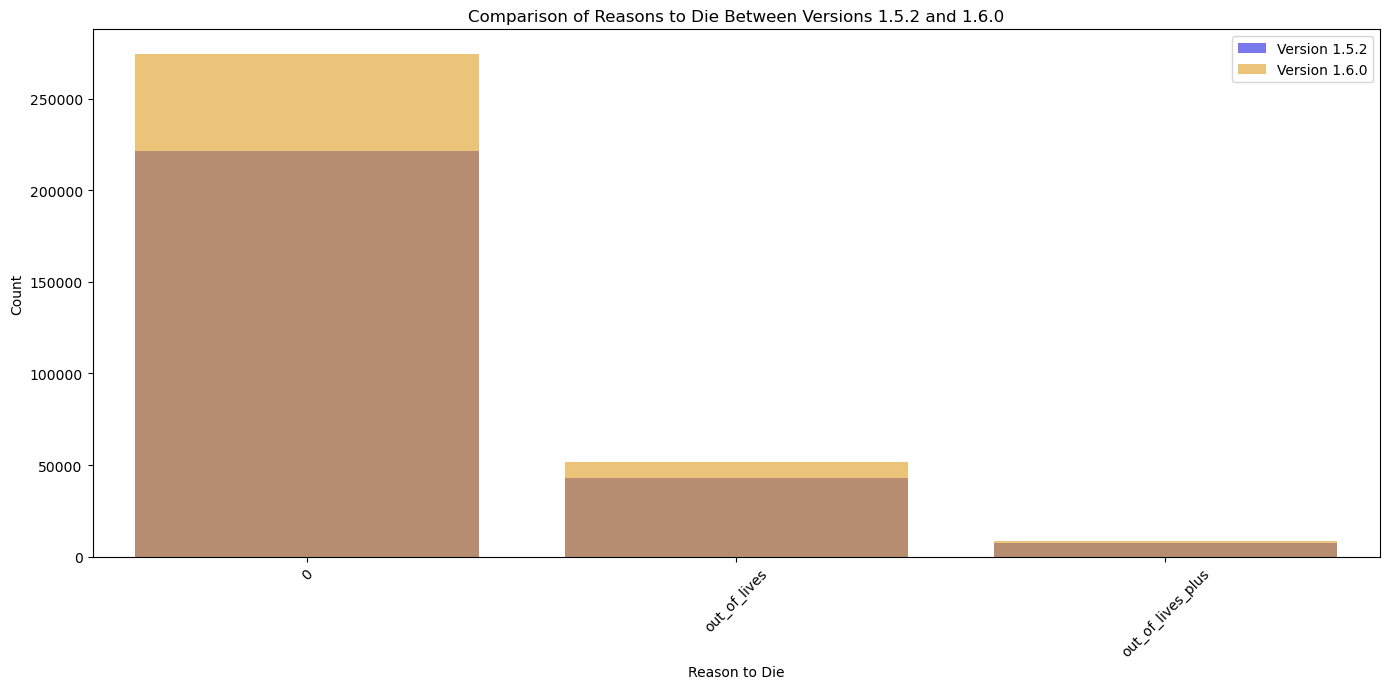

Chi-square statistic: 19.437565532099455, P-value: 6.014316431050276e-05


In [347]:
# Calculate the frequency of each reason_to_die for each version
reason_1_5_2 = data_1_5_2['reason_to_die'].value_counts().reset_index()
reason_1_5_2.columns = ['reason_to_die', 'count_1_5_2']

reason_1_6_0 = data_1_6_0['reason_to_die'].value_counts().reset_index()
reason_1_6_0.columns = ['reason_to_die', 'count_1_6_0']

# Merge the two dataframes on reason_to_die
reason_comparison = pd.merge(reason_1_5_2, reason_1_6_0, on='reason_to_die', how='outer').fillna(0)

# Plot the comparison
plt.figure(figsize=(14, 7))
sns.barplot(x='reason_to_die', y='count_1_5_2', data=reason_comparison, color='blue', alpha=0.6, label='Version 1.5.2')
sns.barplot(x='reason_to_die', y='count_1_6_0', data=reason_comparison, color='orange', alpha=0.6, label='Version 1.6.0')
plt.title('Comparison of Reasons to Die Between Versions 1.5.2 and 1.6.0')
plt.xlabel('Reason to Die')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Perform chi-square test
contingency_table = reason_comparison[['count_1_5_2', 'count_1_6_0']].to_numpy()
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2_stat}, P-value: {p_value}")
#The significant chi-square test result for reasons to die suggests changes in gameplay dynamics between the versions.